<a href="https://colab.research.google.com/github/JaerongA/syllable_network_analysis/blob/main/syllable_network_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Song syllable sequence analysis

### Load data


In [1]:
import IPython
import IPython.display as ipd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from numpy import random
from pathlib import Path
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# sample data from one recording session
syllables = 'kiiiiabcdjiabcdjiabcd*iiiabcdk*iiii*iiiabcdjiabcdk*kiiiiiabcdjia*kiiiiiabcdjjabcd*iiiiabcd*iiiiabcdk*iiiiab*k*iiiiabcdk*iiiabcdjiabcd*iiiabcd*iiiabcdjiabcdk*iiabcd*iiiiiabcdjiabcd*iiiiabcd*iiiiiabcdjiabcdk*k*iiiabcdjiak*iiiabcdjiaj*kmmiiiabcdjiabcd*iiiiabcdjiabcd*iiiiiabcdk*iiiiabcdjiabcd*iiiiabcd*'
song_note = ('a', 'b', 'c', 'd')
calls = ('m')
intro_notes = ('i')
note_seq = ('i', 'a', 'b', 'c', 'd', 'j', 'k', 'm', '*') # syllabic sequence, asterisk indicates stop
song_name = '017-g35r38-Predeafening-D36-20190617'
cmap_list = ["YlGnBu", "PiYG"]

In [2]:
# Count the number of notes (except for stop)
note_count = {}

for note in set(syllables):
    note_count[note] = syllables.count(note)
note_count.pop('*')
note_count

{'i': 104, 'd': 33, 'c': 33, 'k': 14, 'b': 34, 'm': 2, 'a': 37, 'j': 16}

### Play sample songs

In [3]:
data_dir = Path("./data/")
audio_files = list(data_dir.glob('*.wav'))
for file in audio_files:
    print(file.name)
    ipd.display(ipd.Audio(file)) 

g35r38_190617_155056_Dir.wav


### Assign different colors for different syllables

In [4]:
motif_color = ['r', 'b', 'lime', 'm', 'darkorange', 'purple', 'saddlebrown']
intro_color = ['k', 'gray', 'darkseagreen', 'olive'] 
call_color = ['teal', 'darkslategray', 'darkgray','indigo']

song_note = ['a', 'b', 'c', 'd']
calls = ['m']
intro_notes = ['i']

syl_color = []

for i, note in enumerate(note_seq[:-1]):
    if note in song_note:
        syl_color.append(motif_color.pop(0))
    elif note in intro_notes:
        syl_color.append(intro_color.pop(0))
    elif note in calls:
        syl_color.append(call_color.pop(0))
    else:
        syl_color.append(intro_color.pop(0))
        
syl_color.append('y') # for stop at the end 

print(note_seq)
print(syl_color)

('i', 'a', 'b', 'c', 'd', 'j', 'k', 'm', '*')
['k', 'r', 'b', 'lime', 'm', 'gray', 'darkseagreen', 'teal', 'y']


### Build a transition matrix

In [5]:
def get_trans_matrix(syllables, note_seq, norm = False):
    
    trans_matrix = np.zeros((len(note_seq), len(note_seq)), dtype='float32')  # initialize the matrix
    normalize = 0
    for i, note in enumerate(syllables):

        if i < len(syllables) - 1:
            #print(syllables[i] + '->' + syllables[i + 1])
            ind1 = note_seq.index(syllables[i])
            ind2 = note_seq.index(syllables[i + 1])
            if ind1 < len(note_seq)-1:
                #trans_matrix[ind1, ind2] = trans_matrix[ind1, ind2] + 1
                trans_matrix[ind1, ind2] += 1

    if norm:  # normalize by the total sum 
        print("normalize")
        trans_matrix = c /trans_matrix.sum()
    return trans_matrix
    
trans_matrix = get_trans_matrix(syllables, note_seq)
print(trans_matrix)

[[67. 36.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0. 34.  0.  0.  1.  1.  0.  1.]
 [ 0.  0.  0. 33.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0. 33.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 14.  7.  0. 12.]
 [13.  1.  0.  0.  0.  1.  0.  0.  1.]
 [ 3.  0.  0.  0.  0.  0.  0.  1. 10.]
 [ 1.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]


### Build the syllable network (start & end nodes and weights)

In [6]:
# weights = number of transitions
syl_network = ()
start_node = np.transpose(np.nonzero(trans_matrix))[:,0].T.tolist()
end_node = np.transpose(np.nonzero(trans_matrix))[:,1].T.tolist()
weight = []

for ind in range(0, len(start_node)):
    weight.append(int(trans_matrix[start_node[ind], end_node[ind]]))
    
syl_network = list(zip(start_node, end_node, weight))
print(syl_network)

[(0, 0, 67), (0, 1, 36), (0, 8, 1), (1, 2, 34), (1, 5, 1), (1, 6, 1), (1, 8, 1), (2, 3, 33), (2, 8, 1), (3, 4, 33), (4, 5, 14), (4, 6, 7), (4, 8, 12), (5, 0, 13), (5, 1, 1), (5, 5, 1), (5, 8, 1), (6, 0, 3), (6, 7, 1), (6, 8, 10), (7, 0, 1), (7, 7, 1)]


## Plot transition matrix

- Row = initial state, column = terminal state
- Number of transitions represented in a colormap
- colormap reference (https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html)

In [7]:
def plot_trans_matrix(trans_matrix, note_seq, cmap = "YlGnBu", linecolor= 'k'):
    
    y_max = trans_matrix.max() + (10 - trans_matrix.max() % 10)
    ax = sns.heatmap(trans_matrix, cmap =cmap, annot = True, vmin=0, vmax= y_max, 
                          linewidth = 1, linecolor=linecolor,
                          cbar_kws=dict(ticks=[0, y_max/2, y_max], label='# of transitions') )

    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True) # move the xtick label on the top of the figure
    ax.set_aspect(aspect=1)
    ax.set_yticklabels(note_seq, rotation = 0, weight='bold', fontsize= 12)
    ax.set_xticklabels(note_seq, weight ='bold', fontsize= 12)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    cbar = ax.collections[0].colorbar

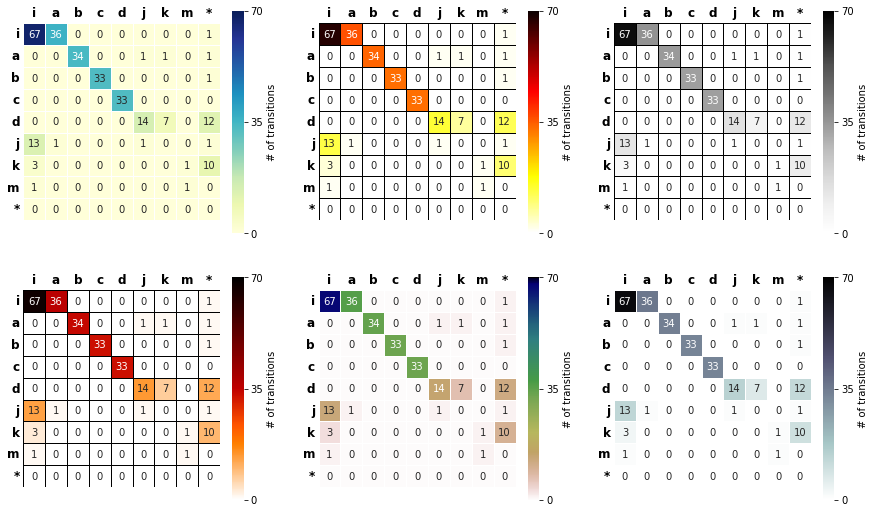

In [8]:
# Plot transition heatmap (in difference color scheme)
fig, axes = plt.subplots(2,3, figsize = (15, 9))

plt.subplot(2,3,1)
plot_trans_matrix(trans_matrix, note_seq, linecolor = 'w')

plt.subplot(2,3,2)
plot_trans_matrix(trans_matrix, note_seq, cmap = "hot_r")

plt.subplot(2,3,3)
plot_trans_matrix(trans_matrix, note_seq, cmap = "Greys")

plt.subplot(2,3,4)
plot_trans_matrix(trans_matrix, note_seq, cmap = "gist_heat_r")

plt.subplot(2,3,5)
plot_trans_matrix(trans_matrix, note_seq, cmap = "gist_earth_r", linecolor = 'w')

plt.subplot(2,3,6)
plot_trans_matrix(trans_matrix, note_seq, cmap = "bone_r", linecolor = 'w')

## Calculate transition entropy

- Transition entropy = 0 when there's a single transition and increases with more branching points

In [63]:
def get_trans_entropy(trans_matrix, weighted=False, ignore_repeats=False):
    
    matrix = trans_matrix.copy()
    
    if ignore_repeats:
        np.fill_diagonal(matrix, 0)
        
    trans_entropy = []
    for row in matrix:
        if np.sum(row):
            prob = row / np.sum(row)
            entropy = -np.nansum(prob * np.log2(prob))
            if weighted:
                note_prob = np.sum(row) / np.sum(matrix)
                entropy *= note_prob
            trans_entropy.append(entropy)
    #print(trans_entropy)    
    trans_entropy = np.mean(trans_entropy)
    return trans_entropy

# trans_entropy = get_trans_entropy(trans_matrix)
# print(f'transition entropy is : {trans_entropy}')

trans_entropy = get_trans_entropy(trans_matrix)
print(f'transition entropy is : {trans_entropy}')

transition entropy is : 0.7933934330940247


## Plot song transition diagram

- Each syllable constitutes a node and will be assigned a distinct color.
- Syllable transitions will be denoted as connection lines with the color matching that of a syllable

In [64]:
def plot_transition_diag(note_seq, syl_network, syl_color, linewidth = 0.4, dev_factor = 0.6):
    
    import math
    np.random.seed(0)
    
    # Set node location
    theta = np.linspace(-math.pi, math.pi, num=len(note_seq)+1)  # for each node
    circle_size = 0.23  # cirlce size for the repeat syllable
    
    node_xpos = [math.cos(node) for node in theta ]
    node_ypos = [math.sin(node) for node in theta ][::-1]
    
    # Plot the syllable node
    fig, ax = plt.subplots(1, 1, figsize =(5, 5))
    ax.axis('off')
    ax.set_aspect('equal', adjustable='datalim')
    plt.scatter(node_xpos[:-1], node_ypos[:-1], s= 800, facecolors='w', edgecolors=syl_color, zorder = 2.5, linewidth = 3)
    
    for i, (start_node, end_node, weight)  in enumerate(syl_network):
        
        if start_node != end_node: # transition syllable
            
            start_nodex = node_xpos[start_node] + (np.random.uniform(-dev_factor, dev_factor, weight)/10)
            start_nodey = node_ypos[start_node] + (np.random.uniform(-dev_factor, dev_factor, weight)/10)
        
            end_nodex = node_xpos[end_node] + (np.random.uniform(-dev_factor, dev_factor, weight)/10)
            end_nodey = node_ypos[end_node] + (np.random.uniform(-dev_factor, dev_factor, weight)/10)            
            
            plt.scatter(start_nodex, start_nodey, s = 0, facecolors = 'k')
            plt.scatter(end_nodex, end_nodey, s = 0, facecolors = 'k')
            plt.plot([start_nodex, end_nodex], [start_nodey, end_nodey], 'k', color= syl_color[start_node], linewidth = linewidth)
            
        else:  # repeating syllables
            
            factor = 1.25  # adjust center of the circle for the repeat
            syl_loc = ((np.array(node_xpos) * factor).tolist(), (np.array(node_ypos) * factor).tolist())
            
            start_nodex = syl_loc[0][start_node] + (np.random.uniform(-0.8,0.8,weight)/8)
            start_nodey = syl_loc[1][start_node] + (np.random.uniform(-0.8,0.8,weight)/8)
            
            for x,y in zip(start_nodex, start_nodey):
                circle= plt.Circle((x,y), circle_size, color = syl_color[start_node], fill=False, clip_on=False, linewidth =0.5 )
                ax.add_artist(circle)
                
       # Set text labeling location
        factor = 1.7
        text_loc = ((np.array(node_xpos) * factor).tolist(), (np.array(node_ypos) * factor).tolist())         

        for i, note in enumerate(note_seq):
            ax.text(text_loc[0][i], text_loc[1][i], note_seq[i], fontsize=15)        
    
    # Calculate transition entropy
    trans_entropy = get_trans_entropy(trans_matrix)
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    
    msg = f"Transition Entropy \n\n = {trans_entropy : 0.3f}"
    # msg = 'Transition entropy \n\n  = {}'.format(round(trans_entropy,3))
    plt.text(2, 0, msg, fontsize = 12)

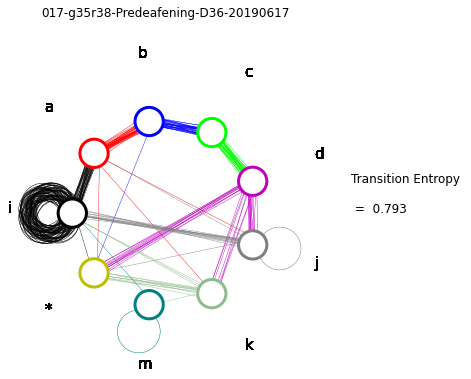

In [65]:
# Plot transition diagram
plot_transition_diag(note_seq, syl_network, syl_color)
plt.title(song_name, y= 1.2)
plt.show()

## Sequence linearity & sequence consistency (Scharff & Nottebohm 1991)




- A value closer to 1 indicates more stereotyped linearity or consistency of the syllable sequence<br />


\begin{equation}
sequence\ linearity = \frac{(number\ of\ unique\ syllables )}{(number\ of\ unique\ transitions\ )}
\end{equation}<br />



\begin{equation}
sequence\ consistency = \frac{(number\ of\ typical\ transitions )}{(total\ number\ of\ possible\ transitions\ )}
\end{equation}<br />


\begin{equation}
song\ stereotypy = \frac{sequence\ linearity + sequency\ consistency}{2}
\end{equation}<br />

- Note that I included stop syllable (*) in this calculation <br /><br />

In [12]:
def get_sequence_linearity(note_seq, syl_network):
    
    nb_unique_transitions  = len(syl_network)
    #print(nb_unique_transitions)
    nb_unique_syllables = len(note_seq)-1  # stop syllable (*) not counted here
    sequence_linearity = nb_unique_syllables/nb_unique_transitions
    #print(nb_unique_syllables)
    return sequence_linearity

sequence_linearity = get_sequence_linearity(note_seq, syl_network)
f"sequence linearity is : {sequence_linearity : .3f}"

'sequence linearity is :  0.364'

In [13]:
def get_sequence_consistency(note_seq, trans_matrix):

    typical_transition = []
    for i, row in enumerate(trans_matrix):

        max_ind = np.where(row == np.amax(row))
        note_seq
        if ((max_ind[0].shape[0]) ==1) and (np.sum(row)): # skip if there are more than two max weight values or the sum of weights equals zero
            #print(f"{note_seq[i]} -> {note_seq[max_ind[0][0]]}") # starting syllable -> syllable with the highest prob of transition"
            typical_transition.append((note_seq[i],note_seq[max_ind[0][0]]))

    nb_typical_transition = len(typical_transition) 
    nb_total_transition = np.count_nonzero(trans_matrix)       

    sequence_consistency = nb_typical_transition/nb_total_transition
    return sequence_consistency

sequence_consistency = get_sequence_consistency(note_seq, trans_matrix)
f"sequence linearity is : {sequence_consistency : .3f}"

'sequence linearity is :  0.318'

In [14]:
def get_song_stereotypy(sequence_linearity, sequence_consistency):
    """Average between linearity and consistency"""
    song_stereotypy = (sequence_linearity + sequence_consistency)/2
    return song_stereotypy

song_stereotypy = get_song_stereotypy(sequence_linearity, sequence_consistency)
f"song stereotypy is : {song_stereotypy : .3f}"

'song stereotypy is :  0.341'

## Build Markov matrix

In [16]:
markov_matrix = trans_matrix.copy()

for ind, row in enumerate(trans_matrix):
#     print(row)
    if np.sum(row):
        markov_matrix[ind] /= np.sum(row)
        
markov_matrix

array([[0.6442308 , 0.34615386, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00961538],
       [0.        , 0.        , 0.9189189 , 0.        , 0.        ,
        0.02702703, 0.02702703, 0.        , 0.02702703],
       [0.        , 0.        , 0.        , 0.9705882 , 0.        ,
        0.        , 0.        , 0.        , 0.02941176],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.42424244, 0.21212122, 0.        , 0.36363637],
       [0.8125    , 0.0625    , 0.        , 0.        , 0.        ,
        0.0625    , 0.        , 0.        , 0.0625    ],
       [0.21428572, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.07142857, 0.71428573],
       [0.5       , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.5       , 0.        ],


## Canonical transition probability

- Only calculates it within the song note.
- From the motif starting syllable to its penultinum syllable.

In [60]:
def get_canonical_trans_prob(trans_matrix, note_seq):
    """Calculate transition probability within a canonical song motif"""
    
    # Find number of transitions within a song motif up to the penultimate syllable
    trans_dict = {}
    note_to_use = song_note[:-1]

    for ind, note in enumerate(note_seq):
        if note in note_to_use:
            trans_dict[note] = trans_matrix[ind]

    # Calculate canonical transition probability
    all_transitions = 0
    canonical_transitions = 0

    for note, transition in trans_dict.items():
        canonical_transitions += transition[note_seq.index(note) + 1]
        all_transitions += np.sum(transition)

    return canonical_transitions / all_transitions

canonical_trans_prob = get_canonical_trans_prob(trans_matrix, note_seq)
print(canonical_trans_prob)

0.9615384615384616
